# Explore and Clean data
We use the job postings at 2023 to gain buisness insights and to predict the future job market. The dataset is from [kaagle](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings). This dataset includes 3 sets of data and one job posting csv file : Company detials, job details, maps. 

This notebook will epxlore, clean and merge all the data into one dataset so the team can use one clean dataset to play with llm.


## Summary

## Table of contents
- [company details](#company-details-dataset)

In [3]:
import pandas as pd
import numpy as np

## Company details dataset
This includes 4 csv files, companies.csv, company_industries.csv, company_specialities.csv, employee_counts.csv

In [40]:
# companies.csv
df_comp = pd.read_csv('company_details/companies.csv')
df_comp.head(5)

,company_id,name,description,company_size,state,country,city,zip_code,address,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare
2,1021,GE Power,"GE Power, part of GE Vernova, is a world energ...",7.0,NY,US,Schenectady,12345,1 River Road,https://www.linkedin.com/company/gepower
3,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...
4,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle


This dataset includes info for companies, and we can only use the companies that only from US and Canada since we only care about the companies that are in the US and Canada.

In [41]:
# only look at the companies that is from US and canda
df_comp = df_comp[(df_comp['country'] == 'US') | (df_comp['country'] == 'CA')]

In [39]:
# company_industries.csv
df_industry = pd.read_csv('company_details/company_industries.csv')
df_industry.head(3)

,company_id,industry
0,81149246,Higher Education
1,10033339,Information Technology & Services
2,6049228,Accounting


This data tells us the industry of the company

In [ ]:
# Check duplicates
df_industry['company_id'].value_counts()

company_id
1051620     2
72015472    2
73832604    2
13242175    2
10545600    2
           ..
28389122    1
80006625    1
16154370    1
75193       1
373873      1
Name: count, Length: 11273, dtype: int64

For a company, it may involve in multiple industries, let check in details


In [52]:
duplicate_5 = df_industry['company_id'].value_counts().index[:5]
df_industry[df_industry['company_id'].isin(duplicate_5)].sort_values('company_id')

,company_id,industry
1768,1051620,Information Technology & Services
6297,1051620,IT Services and IT Consulting
1254,10545600,Staffing & Recruiting
9229,10545600,Staffing and Recruiting
1256,13242175,Information Technology & Services
6156,13242175,IT Services and IT Consulting
1238,72015472,Information Technology & Services
6003,72015472,IT Services and IT Consulting
5352,73832604,Internet
12270,73832604,"Technology, Information and Internet"


For a company with different industries, their industries have the similar meaning but different names, so we can combine them.


In [ ]:
def merge_duplicates(df, groupby_feature, merge_feature):
    """
    Merge duplicates by ', ' in a dataframe.

    Do this because we want to save as much information as possible.
    """
    return df.groupby(groupby_feature)[merge_feature].apply(lambda x: ', '.join(x.astype(str))).reset_index()

In [53]:
df_industry = merge_duplicates(df_industry, 'company_id', 'industry')
df_industry.head()

,company_id,industry
0,1009,"Information Technology & Services, IT Services..."
1,1016,"Hospital & Health Care, Hospitals and Health Care"
2,1021,"Renewables & Environment, Renewable Energy Sem..."
3,1025,"Information Technology & Services, IT Services..."
4,1028,"Information Technology & Services, IT Services..."


In [ ]:
df_industry.industry.nunique() 

312

there are 232 industries, we can ask ai with the given industry to select the industry that is most relevant to the company.

In [54]:
df_specialities = pd.read_csv('company_details/company_specialities.csv')
df_specialities.head(3)

,company_id,speciality
0,81149246,Childrens Music Education
1,81149246,Foundational Music Theory
2,81149246,Child Music Lessons


This dataset tells what the company's specialities are

We can group the specialities into several categories, and then let the AI to choose which category our competitors are in.

In [55]:
# check duplicates
df_specialities['company_id'].value_counts()

company_id
226965      84
13423341    77
327412      50
14407234    46
949346      46
            ..
93173555     1
28352        1
6683229      1
8967         1
373873       1
Name: count, Length: 8354, dtype: int64

One company could have more than 50 specialities, which is probably a big company. Let check the top one as an example:

In [58]:
df_specialities[df_specialities['company_id']==226965].head(10)

,company_id,speciality
17590,226965,Staff Augmentation
17591,226965,Direct Hires
17592,226965,RPO
17593,226965,Contingent Hiring
17594,226965,Application Development
17595,226965,Product Development
17596,226965,Project Management
17597,226965,Infrastructure Management
17598,226965,IT Support Services
17599,226965,Call Center Services


In [ ]:
# Aggregate the specialties into a single string for each company_id
df_specialities = merge_duplicates(df_specialities, 'company_id', 'speciality')
df_specialities.head()

,company_id,speciality
0,1009,"Cloud, Mobile, Cognitive, Security, Research, ..."
1,1016,"Healthcare, Biotechnology"
2,1021,"Distributed Power, Gasification, Generators, H..."
3,1028,"enterprise, software, applications, database, ..."
4,1033,"Management Consulting, Systems Integration and..."


In [59]:
df_emp_count = pd.read_csv('company_details/employee_counts.csv')
df_emp_count['time_recorded'] = pd.to_datetime(df_emp_count['time_recorded'], unit='s')
df_emp_count.head(3)

,company_id,employee_count,follower_count,time_recorded
0,81149246,6,91,2023-08-21 19:04:04.277973413
1,10033339,3,187,2023-08-21 19:04:04.277973413
2,6049228,20,82,2023-08-21 19:04:05.101318359


We can filter or catergorize the companies by the number of employees to see different levels of competitors.

In [60]:
df_emp_count['company_id'].value_counts()   

company_id
1318        6
1028        6
1681        6
3626        6
1603        5
           ..
1456190     1
79804728    1
3954657     1
49455       1
373873      1
Name: count, Length: 11323, dtype: int64

For this dataframe, we will take the latest employee count for each company_id, because we are interested in the most recent data.

In [61]:
# for duplicated company_id rows, keep the row has the lastest time_recorded
df_emp_count = df_emp_count.sort_values('time_recorded').drop_duplicates('company_id', keep='last')

## Job details dataset
This includes 4 csv files, benefits.csv, job_industries.csv, job_skills.csv, salaries.csv

In [10]:
# benefits.csv
df_benefits = pd.read_csv('job_details/benefits.csv')
df_benefits.head(3)

,job_id,inferred,type
0,3690843087,0,Medical insurance
1,3690843087,0,Dental insurance
2,3690843087,0,401(k)


In [11]:
df_benefits['type'].value_counts()

type
401(k)                     9483
Medical insurance          4395
Vision insurance           4323
Dental insurance           3500
Disability insurance       2961
Tuition assistance         1184
Paid maternity leave        931
Paid paternity leave        864
Commuter benefits           837
Pension plan                518
Student loan assistance     165
Child care support          164
Name: count, dtype: int64

A job could have several benefits, so we need to group by job_id

In [12]:
# job_industries.csv
df_job_industry = pd.read_csv('job_details/job_industries.csv')

# job_skills.csv
df_skills= pd.read_csv('job_details/job_skills.csv')

# job_titles.csv
df_salary = pd.read_csv('job_details/salaries.csv')

In [13]:
df_job_industry.head(3)

,job_id,industry_id
0,3378133231,68
1,3497509795,96
2,3690843087,47


In [14]:
print(f"Unique industries: {df_job_industry['industry_id'].nunique()}, Unique jobs: {df_job_industry['job_id'].nunique()}")

Unique industries: 229, Unique jobs: 33090


In [15]:
df_skills.head(3)

,job_id,skill_abr
0,3690843087,ACCT
1,3690843087,FIN
2,3691763971,MGMT


In [16]:
df_salary.head(3)

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3378133231,30.0,NaN,22.0,HOURLY,USD,BASE_SALARY
1,2,3690843087,65000.0,NaN,55000.0,YEARLY,USD,BASE_SALARY
2,3,3691794313,22.0,NaN,19.0,HOURLY,USD,BASE_SALARY


## Map dataset

In [17]:
industries_df = pd.read_csv('maps/industries.csv')
industries_df.head(3)

,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development


In [18]:
df_skills_map = pd.read_csv('maps/skills.csv')
df_skills_map.head(3)


,skill_abr,skill_name
0,PRCH,Purchasing
1,SUPL,Supply Chain
2,PR,Public Relations


## Job postings dataframe & Combine all the data into one dataframe

In [36]:
df_jobs = pd.read_csv('job_postings.csv')
df_jobs.head(3)

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.0,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,Entry level,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,NaN,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,NaN,NaN,Bachelor's Degree in Mechanical Engineering pr...,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644


only look at the companies that is from US and Canada


In [ ]:
df_industry = df_industry[df_industry['company_id'].isin(df_comp['company_id'])]

will only select the companies that has the industry information


In [64]:
selected_company_id = df_industry['company_id'].unique()

In [65]:
# job info for north america companies
na_job_df = df_jobs[df_jobs['company_id'].isin(selected_company_id)]

In [66]:
na_job_df.head().T

,0,1,2,3,4
job_id,3757940104,3757940025,3757938019,3757938018,3757937095
company_id,553718.0,2192142.0,474443.0,18213359.0,437225.0
title,Hearing Care Provider,Shipping & Receiving Associate 2nd shift (Beav...,"Manager, Engineering",Cook,Principal Cloud Security Architect (Remote)
description,Overview\n\nHearingLife is a national hearing ...,Metalcraft of Mayville\nMetalcraft of Mayville...,\nThe TSUBAKI name is synonymous with excellen...,descriptionTitle\n\n Looking for a great oppor...,"Job Summary\nAt iHerb, we are on a mission to ..."
max_salary,NaN,NaN,NaN,NaN,275834.0
med_salary,5250.0,NaN,NaN,22.27,NaN
min_salary,NaN,NaN,NaN,NaN,205956.0
pay_period,MONTHLY,NaN,NaN,HOURLY,YEARLY
formatted_work_type,Full-time,Full-time,Full-time,Full-time,Full-time
location,"Little River, SC","Beaver Dam, WI","Bessemer, AL","Aliso Viejo, CA",United States


In [67]:
na_job_df.columns

Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'scraped'],
      dtype='object')

In [68]:
na_job_df.skills_desc

0                                                      NaN
1                                                      NaN
2        Bachelor's Degree in Mechanical Engineering pr...
3                                                      NaN
4                                                      NaN
                               ...                        
33238                                                  NaN
33240                                                  NaN
33241                                                  NaN
33243                                                  NaN
33245    Must be a seasoned stylist with an existing bo...
Name: skills_desc, Length: 29869, dtype: object

could clean this part by combining the job_skills.csv and skills.csv

In [ ]:
na_job_df.shape

(29869, 28)

In [ ]:
def merge_df(df1, df2, on_col):
    df = pd.merge(df1, df2, on=on_col, how='left')
    print(f'new dataframe size: \n{df.shape}\nnew features added:\n{df.columns[~df.columns.isin(df1.columns)]}')
    return df

job_company_df = merge_df(na_job_df, df_comp, ['company_id'])


new dataframe size: 
(29869, 37)
new features added:
Index(['description_x', 'name', 'description_y', 'company_size', 'state',
       'country', 'city', 'zip_code', 'address', 'url'],
      dtype='object')


In [ ]:
job_company_df2 = merge_df(job_company_df, df_industry, ['company_id'])  

new dataframe size: 
(29869, 38)
new features added:
Index(['industry'], dtype='object')


In [ ]:
job_company_df3 = merge_df(job_company_df2, df_specialities, ['company_id'])

new dataframe size: 
(29869, 39)
new features added:
Index(['speciality'], dtype='object')


In [ ]:
job_company_df4 = merge_df(job_company_df3, df_emp_count, ['company_id'])

new dataframe size: 
(29869, 42)
new features added:
Index(['employee_count', 'follower_count', 'time_recorded'], dtype='object')


In [ ]:
df_job_industry.head()

,job_id,industry_id
0,3378133231,68
1,3497509795,96
2,3690843087,47
3,3691775263,112
4,3691779379,80


In [ ]:
job_industry_df = merge_df(df_job_industry, industries_df, ['industry_id'])
df_job_industry.shape

new dataframe size: 
(44091, 3)
new features added:
Index(['industry_name'], dtype='object')


(44091, 2)

In [ ]:
# rename "industry_name" to "job_industry"
df_job_industry.rename(columns={'industry_name': 'job_industry'}, inplace=True)

In [ ]:
job_industry_df.job_id.value_counts()

job_id
3749377399    3
3757468088    3
3693068713    3
3699071946    3
3699073806    3
             ..
3701155623    1
3701155578    1
3701155378    1
3701155279    1
3757498232    1
Name: count, Length: 33090, dtype: int64

In [ ]:
job_industry_df[['industry_id', 'job_id']].value_counts()

industry_id  job_id    
1            3690661006    1
84           3756106806    1
             3755583363    1
             3755585008    1
             3755591084    1
                          ..
27           3756113472    1
             3756113649    1
             3756114136    1
             3756114201    1
3251         3757356756    1
Name: count, Length: 44091, dtype: int64

In [ ]:
job_industry_df[['job_id', 'industry_id']].value_counts()

job_id      industry_id
3958427     18             1
3755591504  80             1
3755591450  104            1
3755591453  122            1
3755591455  104            1
                          ..
3699063015  104            1
3699063038  84             1
3699063042  28             1
            36             1
3757940104  17             1
Name: count, Length: 44091, dtype: int64

In [ ]:
job_industry_df.head()

,job_id,industry_id,industry_name
0,3378133231,68,Higher Education
1,3497509795,96,IT Services and IT Consulting
2,3690843087,47,Accounting
3,3691775263,112,"Appliances, Electrical, and Electronics Manufa..."
4,3691779379,80,Advertising Services


In [ ]:
# already have industry.. .wonder what the difference between two industries.
job_company_df4.rename(columns={'industry': 'company_industry'}, inplace=True)

In [ ]:
job_industry_df = merge_duplicates(job_industry_df, 'job_id', 'industry_name')

In [ ]:
job_industry_df.shape

(33090, 2)

In [ ]:
job_company_df4.shape

(29869, 42)

In [ ]:
df5 = merge_df(job_company_df4, job_industry_df, ['job_id'])

new dataframe size: 
(29869, 43)
new features added:
Index(['industry_name'], dtype='object')


In [ ]:
df5['company_id'].isnull().sum()

0

In [ ]:
merged_skill_df = merge_df(df_skills, df_skills_map, ['skill_abr'])


new dataframe size: 
(56591, 3)
new features added:
Index(['skill_name'], dtype='object')


In [ ]:
merged_skill_df = merge_duplicates(merged_skill_df, 'job_id', 'skill_name')


In [ ]:
merged_skill_df.head()

,job_id,skill_name
0,3958427,"Design, Art/Creative, Information Technology"
1,85008768,"Sales, Business Development"
2,102339515,"Business Development, Sales"
3,108965123,Administrative
4,133114754,"Sales, Business Development"


In [ ]:
merged_skill_df.rename(columns={'skill_name': "job_skill"}, inplace=True)

In [ ]:
df6 = merge_df(df5, merged_skill_df, ['job_id'])

new dataframe size: 
(29869, 44)
new features added:
Index(['job_skill'], dtype='object')


In [ ]:
df6.to_csv('df.csv', index=False)

In [ ]:
df6

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,zip_code,address,url,company_industry,speciality,employee_count,follower_count,time_recorded,industry_name,job_skill
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,Retail,"Digital Hearing Instruments, behind ear, in ea...",1171,11417,2023-11-04 20:58:01,Medical Equipment Manufacturing,Other
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,Industrial Machinery Manufacturing,"Metal Fabrication, Machining, Robotic Welding,...",300,2923,2023-11-04 08:10:20,Industrial Machinery Manufacturing,"Management, Manufacturing"
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,Automation Machinery Manufacturing,"Roller Chain, Engineering Class Chain, Sprocke...",314,8487,2023-11-04 08:14:04,Automation Machinery Manufacturing,Engineering
3,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...,Non-profit Organization Management,NaN,36,305,2023-08-24 07:54:56,Non-profit Organizations,"Management, Manufacturing"
4,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb,Retail,"Vitamins, Sports Nutrition, Natural Supplement...",1260,51651,2023-11-04 02:07:22,"Retail, Manufacturing, Technology, Information...",Information Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29864,381055942,96654609.0,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,NaN,NaN,NaN,NaN,Full-time,"Forney, TX",...,75126,1003 College St,https://www.linkedin.com/company/fbc-forney,Religious Institutions,NaN,0,0,2023-08-23 23:07:28,Religious Institutions,NaN
29865,133196985,1089558.0,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,NaN,NaN,Contract,"New York, NY",...,08873,285 Davidson Ave,https://www.linkedin.com/company/employvision,Staffing & Recruiting,NaN,50,16176,2023-11-03 20:09:20,Staffing and Recruiting,"Accounting/Auditing, Finance"
29866,133114754,77766802.0,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",...,28358,Constellation Rd,https://www.linkedin.com/company/cargologinllc,Transportation/Trucking/Railroad,"Export & Import Clearance, Bonded Warehousing,...",15,159,2023-08-23 23:50:57,Truck Transportation,"Sales, Business Development"
29867,102339515,52132271.0,Franchise Owner,DuctVentz is a dryer and A/C – heat vent clean...,NaN,NaN,NaN,NaN,Full-time,Greater Boston,...,0,0,https://www.linkedin.com/company/dryerventz-du...,Consumer Services,NaN,7,28,2023-11-04 02:04:55,Consumer Services,"Business Development, Sales"


In [ ]:
job_company_df.head()

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,scraped,name,description_y,company_size,state,country,city,zip_code,address,url
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,1699138101,HearingLife,HearingLife is a national hearing care company...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,1699085420,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,1699085644,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...
3,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,1699087461,Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...
4,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,1699085346,"iHerb, LLC",iHerb is on a mission to make health and welln...,5.0,California,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb


In [ ]:
df_benefits.inferred.value_counts()

inferred
0    15749
1    13576
Name: count, dtype: int64

In [ ]:
df_skills= pd.read_csv('job_details/job_skills.csv')
display(df_skills.head(), df_skills.shape,df_skills['job_id'].value_counts())

,job_id,skill_abr
0,3690843087,ACCT
1,3690843087,FIN
2,3691763971,MGMT
3,3691763971,MNFC
4,3691775263,MGMT


(56591, 2)

job_id
3699408117    3
3757484372    3
3701322491    3
3756926087    3
3701322483    3
             ..
3748840865    1
3748840866    1
3748840868    1
3748841567    1
3757498232    1
Name: count, Length: 32422, dtype: int64

In [ ]:
df_skills.skill_abr.nunique()

35

In [ ]:
# To filter companies related to business consultancy based on their descriptions without relying on specific keywords,
# we will use a Natural Language Processing (NLP) approach to understand the context and content of the descriptions.
# This process involves:
# 1. Tokenization: Splitting the text into sentences or words.
# 2. Vectorization: Turning the text into numerical data for analysis.
# 3. Classification: Identifying which descriptions relate to business consultancy.

# Due to the limitations in processing capacity and the absence of direct NLP tools in this environment,
# we'll simulate a simplified approach to identify descriptions that potentially relate to business consultancy.
# We'll focus on identifying descriptions that are likely to indicate consultancy services through general analysis.

# Let's first preprocess the text by lowercasing and removing punctuation to normalize the descriptions.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Preprocessing descriptions
descriptions = df['description_x'].dropna().map(lambda x: x.lower())  # Lowercase descriptions

# Since direct NLP classification isn't feasible here, we'll use TF-IDF vectorization and cosine similarity
# to find descriptions most similar to a generic business consultancy description.
generic_description = ["Business consultancy provides strategic, financial, operational, and technology consulting services to help companies improve their performance and efficiency. We specialize in advising businesses on the best ways to manage and operate their organization, including change management, organizational restructuring, and technology implementation."]

# Vectorizing the descriptions and the generic description
vectorizer = TfidfVectorizer(stop_words='english')
descriptions_tfidf = vectorizer.fit_transform(descriptions)
generic_description_tfidf = vectorizer.transform(generic_description)

# Calculating similarity scores between the generic description and all descriptions in the dataset
similarity_scores = cosine_similarity(generic_description_tfidf, descriptions_tfidf).flatten()

# Identifying descriptions with a high similarity score (e.g., top 5%)
threshold = np.quantile(similarity_scores, 0.95)
similar_descriptions_ids = np.where(similarity_scores >= threshold)[0]

# Extracting the corresponding company IDs
similar_companies = df.iloc[similar_descriptions_ids]['company_id'].dropna().unique()

similar_companies


array([7.30137240e+07, 1.81521800e+06, 1.81186800e+06, 7.88531090e+07,
       1.25783700e+06, 2.27100000e+03, 3.72915000e+05, 1.63139000e+05,
       2.64600000e+03, 4.97017000e+05, 2.03720000e+04, 3.60800000e+03,
       4.06934000e+05, 2.70100000e+03, 6.89300000e+03, 7.83956160e+07,
       1.23500000e+03, 3.32660000e+04, 1.41500000e+03, 3.69500000e+03,
       7.61800000e+07, 7.43346000e+05, 2.70564390e+07, 2.93990000e+04,
       7.43067590e+07, 3.56633470e+07, 2.05856000e+05, 2.51060000e+04,
       8.19382510e+07, 1.46400000e+03, 1.09179830e+07, 2.11820000e+04,
       9.06070000e+05, 1.70179900e+06, 2.55545400e+06, 6.69665590e+07,
       5.08963000e+05, 1.15680000e+04, 3.99182200e+06, 3.34216900e+06,
       3.50989900e+06, 1.69720000e+04, 9.43800000e+03, 1.66388000e+05,
       1.03217900e+07, 4.89600000e+03, 1.06300000e+03, 3.25200000e+03,
       6.86600000e+03, 3.16300000e+03, 7.55000000e+03, 1.81170600e+06,
       1.56476000e+05, 1.64780000e+06, 7.73800000e+03, 3.24780000e+04,
      

In [ ]:
df.columns

Index(['job_id', 'company_id', 'title', 'description_x', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'scraped', 'name', 'description_y', 'company_size',
       'state', 'country', 'city', 'zip_code', 'address', 'url',
       'company_industry', 'speciality', 'employee_count', 'follower_count',
       'time_recorded', 'industry_name', 'job_skill'],
      dtype='object')

In [ ]:
df

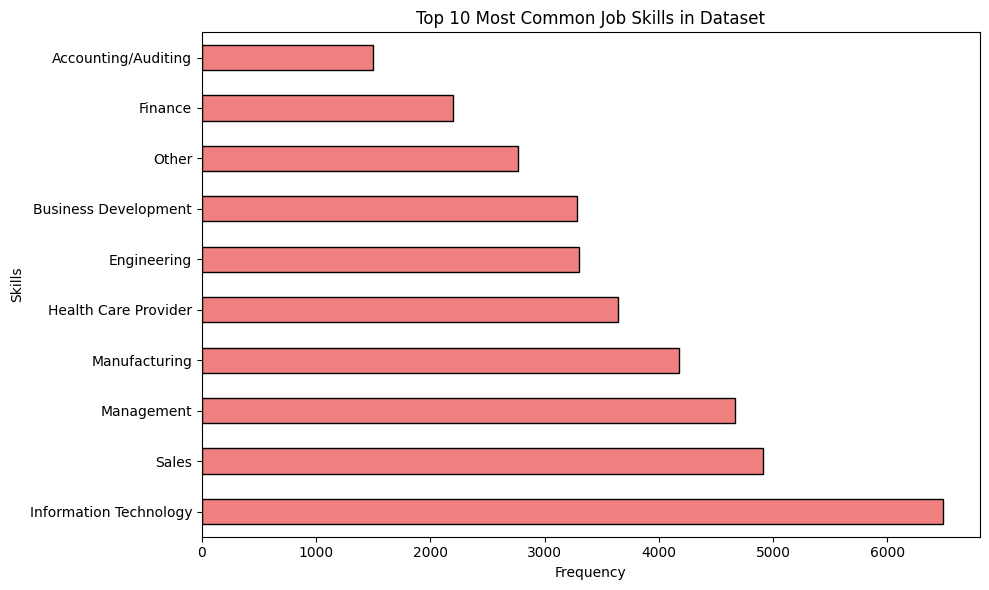

In [ ]:
import matplotlib.pyplot as plt
# Splitting the 'job_skill' strings into lists and then flattening them into a single list
job_skills_series = df['job_skill'].dropna().str.split(', ').explode()

# Counting the occurrences of each skill
job_skills_count = job_skills_series.value_counts()

# Plotting the top 10 most common job skills
fig, ax = plt.subplots(figsize=(10, 6))
job_skills_count.head(10).plot(kind='barh', ax=ax, color='lightcoral', edgecolor='black')
ax.set_title('Top 10 Most Common Job Skills in Dataset')
ax.set_xlabel('Frequency')
ax.set_ylabel('Skills')
plt.tight_layout()
plt.show()


In [ ]:
df.columns

Index(['job_id', 'company_id', 'title', 'description_x', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'scraped', 'name', 'description_y', 'company_size',
       'state', 'country', 'city', 'zip_code', 'address', 'url',
       'company_industry', 'speciality', 'employee_count', 'follower_count',
       'time_recorded', 'industry_name', 'job_skill'],
      dtype='object')

In [ ]:
df[df['company_id'].isin(similar_companies)].sort_values(by='follower_count')

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,zip_code,address,url,company_industry,speciality,employee_count,follower_count,time_recorded,industry_name,job_skill
8794,3756115231,101174062.0,Executive Director,Position OverviewThe Executive Director is the...,90000.00,NaN,80000.00,YEARLY,Full-time,United States,...,0,0,https://www.linkedin.com/company/drag-story-hour,Non-profit Organizations,NaN,0,1,2023-11-04 04:19:47,Non-profit Organizations,"Business Development, Sales"
1083,3757752316,76180000.0,Of Counsel Employment Attorney,Who You Are:You are an employment lawyer that ...,NaN,NaN,NaN,NaN,Part-time,"San Francisco, CA",...,94127,126 W Portal Ave,https://www.linkedin.com/company/fairgrieve-la...,Law Practice,"EMPLOYMENT ADVICE AND COUNSEL, Appeals, Litiga...",1,8,2023-11-04 02:04:55.000000000,Law Practice,Legal
25070,3693589346,96081672.0,MARKETING AND COMMUNICATIONS MANAGER,Job Title:MARKETING AND COMMUNICATIONS MANAGER...,67.95,NaN,50.71,HOURLY,Full-time,"Jurupa Valley, CA",...,92509,8930 Limonite Ave,https://www.linkedin.com/company/the-city-of-j...,Government Administration,NaN,8,13,2023-08-24 01:38:26.000000000,Government Administration,NaN
27966,3693051241,96610751.0,Receptionist & Admin,Position: Receptionist & AdminLocation: Frisco...,NaN,NaN,NaN,NaN,Full-time,"Frisco, TX",...,30097,11024 Taconic Way,https://www.linkedin.com/company/otb-tech-llc,Information Technology & Services,"Staffing, Recruitment , Sales, Marketing, Inte...",6,16,2023-08-23 23:15:37,IT Services and IT Consulting,Administrative
18503,3701150992,90741203.0,Student Ambassador,"UniEra Consulting is a US-based company, estab...",NaN,NaN,NaN,NaN,Internship,"Chicago, IL",...,60605,0,https://www.linkedin.com/company/uniera-consul...,Higher Education,NaN,8,22,2023-08-24 07:12:44,Higher Education,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21721,3697388372,1441.0,"Director, Customer Engineering, Apigee, Google...",Note: By applying to this position you will ha...,320000.00,NaN,218000.00,YEARLY,Full-time,"New York, NY",...,94043,1600 Amphitheatre Parkway,https://www.linkedin.com/company/google,Computer Software,"search, ads, mobile, android, online video, ap...",285785,30600596,2023-11-04 21:23:00,"Information Services, Technology, Information ...","Sales, General Business, Customer Service"
21723,3697388365,1441.0,"Hardware Architect, Machine Learning, Technica...",Minimum qualifications:\n\nBachelor's degree i...,220000.00,NaN,146000.00,YEARLY,Full-time,"Sunnyvale, CA",...,94043,1600 Amphitheatre Parkway,https://www.linkedin.com/company/google,Computer Software,"search, ads, mobile, android, online video, ap...",285785,30600596,2023-11-04 21:23:00,"Information Services, Technology, Information ...","Other, Information Technology, Engineering"
21724,3697388363,1441.0,"Strategy Manager, Google Workspace",Note: By applying to this position you will ha...,194000.00,NaN,130000.00,YEARLY,Full-time,"New York, NY",...,94043,1600 Amphitheatre Parkway,https://www.linkedin.com/company/google,Computer Software,"search, ads, mobile, android, online video, ap...",285785,30600596,2023-11-04 21:23:00,"Information Services, Technology, Information ...","General Business, Strategy/Planning, Consulting"
18962,3699421413,1441.0,"UX Researcher, Pixel",Minimum qualifications:\n\nBachelor's degree i...,172000.00,NaN,118000.00,YEARLY,Full-time,"Mountain View, CA",...,94043,1600 Amphitheatre Parkway,https://www.linkedin.com/company/google,Computer Software,"search, ads, mobile, android, online video, ap...",285785,30600596,2023-11-04 21:23:00,"Information Services, Technology, Information ...","Art/Creative, Design, Engineering"


In [ ]:
df.head().T

,0,1,2,3,4
job_id,3757940104,3757940025,3757938019,3757938018,3757937095
company_id,553718.0,2192142.0,474443.0,18213359.0,437225.0
title,Hearing Care Provider,Shipping & Receiving Associate 2nd shift (Beav...,"Manager, Engineering",Cook,Principal Cloud Security Architect (Remote)
description_x,Overview\n\nHearingLife is a national hearing ...,Metalcraft of Mayville\nMetalcraft of Mayville...,\nThe TSUBAKI name is synonymous with excellen...,descriptionTitle\n\n Looking for a great oppor...,"Job Summary\nAt iHerb, we are on a mission to ..."
max_salary,NaN,NaN,NaN,NaN,275834.0
med_salary,5250.0,NaN,NaN,22.27,NaN
min_salary,NaN,NaN,NaN,NaN,205956.0
pay_period,MONTHLY,NaN,NaN,HOURLY,YEARLY
formatted_work_type,Full-time,Full-time,Full-time,Full-time,Full-time
location,"Little River, SC","Beaver Dam, WI","Bessemer, AL","Aliso Viejo, CA",United States


In [ ]:
# Filtering job titles and descriptions for roles related to consultancy, management, or business development
# and extracting the skills required for these roles

# Filter rows where 'title' or 'description_x' contains keywords related to consultancy
consultancy_keywords = ['consultant', 'consultancy', 'management', 'business development', 'strategy', 'advisor']
filtered_df = df[df['title'].str.contains('|'.join(consultancy_keywords), case=False) | 
                 df['description_x'].str.contains('|'.join(consultancy_keywords), case=False)]

# Extracting and summarizing skills from the 'job_skill' column
skills_series = filtered_df['job_skill'].dropna()  # Drop rows where 'job_skill' is NaN
skills_list = skills_series.str.split(', ').explode()  # Split skills by comma and create a list
skills_count = skills_list.value_counts()  # Count the occurrence of each skill

skills_count.head(10)  # Display the top 10 skills


In [ ]:
df = pd.read_csv('df.csv')
df.name

0                                 HearingLife
1                Metalcraft of Mayville, Inc.
2        U.S. Tsubaki Power Transmission, LLC
3            Episcopal Communities & Services
4                                  iHerb, LLC
                         ...                 
29864             First Baptist Church Forney
29865                       Employvision Inc.
29866                             CargoLogin.
29867                  DryerVentz - DuctVentz
29868                       Karen Marie Salon
Name: name, Length: 29869, dtype: object